In [19]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import ticker
import datetime as dt
import parameters as p

In [20]:
def main(theta, hyds, bch):
    '''
    set surface input data and calculate resistance and Esoil
    '''
    
    # Meteorology input 
    
    # met%ua, observed wind speed away from the surface and canopy (m s-1) 
    Uair = 2.030000
    
    # met%tvair within canopy air temperature (oC)
    tvair = 8.474 # 281.6240-273.15
    
    # met%pmb * 100.0 (Pa)
    pres = 100699.9

    # soil surface temperature (oC)
    Tsrf = 9.911957
    
    # met%qvair, specific humidity of the canopy air/atmosphere (kg kg-1)
    qa = 0.000040238039
    
    # canopy%rghlai, LAI over the whole grid cell (m), it is not Monin-Obhukov length, Decker 2017 made a mistake  
    L  =  2.29
    # canopy%rghlai = veg%vlai * rough%hruff / MAX( 0.01, veg%hc )
    
    # canopy%us friction velocity (CABLE put out)
    Ux = 0.1840812 # ???
    
    # soil matric potential in the first soil layer
    Phi_1 = calc_Phi_1(theta, bch)
    
    # the saturated specific humidity at the surface temperature
    qsat = calc_qsat(Tsrf, pres)
    
    # specific humidity at the soil surface (kg kg-1) 
    qsrf = calc_qsrf(qsat,Phi_1,Tsrf)
    
    # relative wetness at the surface
    theta_srf = (theta - p.theta_r)/(p.theta_sat - p.theta_r)
    
    # canopy friction velocity (m s-1) 
    U_x = calc_U_x(L,Ux)

    # the displacement height of the canopy (m)
    d  = calc_d(L)

    # rough%z0soilsn (m) soil surface roughness height
    Z0s = calc_Z0s(L, U_x)
    
    rg = calc_rg(L, U_x, d, Z0s, Ux)
    rsv = calc_rsv(theta_srf, Tsrf, qsat, bch, hyds)
    rBL,delta = calc_rBL(Uair, U_x, theta, tvair)
    
    # Soil evaporation (W m-2)
    Esoil = calc_esoil(pres, tvair, qsrf, qa, Z0s, delta, rg, rsv, rBL) # 2.252888
    #print(rg)
    #print(rsv)
    #print(rBL)
    #print(Esoil)
    #return rg,rsv,rBL;
    return Esoil

def calc_Phi_1(theta_srf, bch):
    '''
    calculate soil matric potential in the first soil layer
    '''
    Phi_1 = -p.sucs*theta_srf**(-bch)
    # unsat_smp = (sign(ssnow%sucs_hys(i,1),-1.0)*((wb -ssnow%watr_hys)/ &
    #             (ssnow%ssat_hys-ssnow%watr_hys))**(-soil%bch_vec))     &
    #             /m2mm !m
    #print(theta_srf)
    #print(Phi_1)
    return Phi_1
    
    
def calc_qsat(Tsrf,pres):
    '''
    calculate saturated specific humidity at the surface temperature (kg kg-1) 
    
    '''
    qsat = (0.018016/0.02897)*(6.106*np.exp(17.27*Tsrf/(237.3+Tsrf)))/(pres/100.) # 7.5363433E-03    
    # ssnow%qstss= (C%RMH2o/C%rmair)*(C%TETENA*EXP(C%TETENB*(ssnow%tss-C%tfrz)/ &
    #              (C%TETENC+(ssnow%tss-C%tfrz))))/met%pmb
    # rmh2o = 0.018016, molecular wt: water (kg/mol)
    # rmair = 0.02897,  molecular wt: dry air (kg/mol)
    # tetena = 6.106,  Teten coefficients, Magnus Tetans (Murray 1967)
    # tetenb = 17.27, 
    # tetenc = 237.3, 

    return qsat

    
def calc_qsrf(qsat,Phi_1,Tsrf):
    '''
    calculate specific humidity at the soil surface (kg kg-1) 
    '''
    qsrf = qsat*np.exp((Phi_1*p.g)/(p.Rwv*Tsrf))  # 0.999994470977338?
    # ssnow%rh_srf = exp(9.81*unsat_smp/(ssnow%tgg(i,1)*461.4))
    
    return qsrf
    
def calc_Z0s(L, U_x):
    '''
    [different] calculate soil surface roughness height, turbulent airflow's length scale, rough%z0soilsn (m)
    '''
    Z0s = 0.01*L + 0.02*U_x**2/p.g  # 1.0013655E-02
    #rough%z0soil   = 0.01*min(1.0,canopy%vlaiw) + 0.02*min(canopy%us**2/C%GRAV,1.0)
    #rough%z0soilsn = max(1.e-7,rough%z0soil) 
    #print(Z0s)
    return Z0s


def calc_U_x(L,Ux):
    '''
    [different] calculate canopy friction velocity (m s-1) 
    '''

    # Displacement height/canopy height:
    dh = (1.0-(1.0-np.exp(-1.0*np.sqrt(15.*max((L*0.5),0.0005))))/(np.sqrt(15.*max((L*0.5),0.0005))))
  
    # Friction velocity/windspeed at canopy height
    usuh = min(np.sqrt(0.003 + 0.3 * (L*0.5)), 0.3)
    # rough%usuh = MIN( SQRT( C%CSD + C%CRD * ( canopy%rghlai * 0.5 ) ), C%USUHM )
    # csd = 0.003, substrate drag coefficient
    # crd = 0.3, element drag coefficient
    # usuhm = 0.3, (max of us/uh)
        
    # Extinction coefficient for wind profile in canopy
    Cv = usuh/( 0.40 * 2. * (1.0 - dh))
    # rough%coexp = rough%usuh / ( C%VONK * C%CCW_C * ( 1.0 - dh ) )
    # vonk   = 0.40, von Karman constant
    # ccw_c  = 2.0,  ccw=(zw-d)/(h-d)

    U_x = Ux*np.exp(Cv*(1.- p.z/p.h)) 
    # U_x = canopy%us*exp(rough%coexp*(1.0-canopy%sublayer_dz/max(1e-2,rough%hruff))
    # here, canopy%sublayer_dz = 0.005
    
    return U_x

def calc_d(L):
    '''
    [same] calculate displacement height of the canopy, rough%disp (m)
    '''
    d  = (1.0-(1.0-np.exp(-1.0*np.sqrt(15.*max((L*0.5),0.0005))))/(np.sqrt(15.*max((L*0.5),0.0005))))*p.h  # 15.25058     
    # xx = SQRT( 15.0 * MAX( ( canopy%rghlai * 0.5 ), 0.0005 ) )
    # dh = 1.0-(1.0 - EXP(-xx ))/xx, eq.8 Raupach 1994, BLM, vol 71, p211-216:
    # rough%disp = dh * rough%hruff, calculate zero-plane displacement:

    return d

In [21]:
def calc_rg(L, U_x, d, Z0s, Ux):
    '''
    calculate Rg, the aerodynamic resistance from the soil to canopy
    '''

    # sparseness factor (see p.7 in CABLE guide 2016), =1 for bare ground; > 1 when LAI > 1
    fsp = 1./ max(2./3.*p.h/d, 1.) 
    # The larger LAI -> the larger d (d always smaller than h) -> the larger fsp, but fsp cannot larger than 1
    # that is to say, when LAI lower than 1 -> fsp lower than 1 -> rg will increase -> harder to evaporate
    
    # the resistance for both the sensible and latent heat fluxes from the soil to the canopy air 
    #rg  = np.log(d/Z0s)*(np.exp(2.*p.Csw*L)-np.exp((2.*p.Csw*L) *(1 -d/p.h)))/(2.*p.a_3**2*fsp*p.Ctl*p.Csw*L)
    rg  = np.log(d/Z0s)*(np.exp(2.*p.Csw*L)-np.exp((2.*p.Csw*L) *(1 -d/p.h)))/\
          (2.*p.a_3**2*fsp*p.Ctl*p.Csw*L)/Ux
    #(2./3.*p.h/d)*
    # rough%rt0us  = (MAX((2./3.)*rough%hruff/rough%disp,1.0))*LOG(rough%disp/rough%z0soilsn)*
    #                (EXP(2*C%CSW*canopy%rghlai)-EXP(2*C%CSW*canopy%rghlai*(1-rough%disp/rough%hruff)))/
    #                (C%A33**2 * C%CTL * 2 * C%CSW * canopy%rghlai)
    # ssnow%rtsoil(j) = max(rt_min,rough%rt0us) / canopy%us ???
    #print(rg)
    return rg

In [22]:
def calc_rsv(theta_srf, Tsrf, qsrf, bch, hyds):
    '''
    calculate rsv  
    '''

    # hydraulic conductivity of the soil at the surface (m s-1) 
    K = 0.001*hyds*theta_srf**(2.*bch+3.) 
    # hk_zero(i) = max(0.001*soil%hyds_vec(i,1)*(min(max(rel_s(i),0.001_r_2),1._r_2)**(2._r_2*soil%bch_vec(i,1) &
    #              +3._r_2) ),1e-12)

    rsv   = p.gamma/(4.*K)
    # rsv = lm/ (4.0*hk_zero(i))
    
    return rsv

In [23]:
def calc_rBL(Uair, U_x, theta, tvair):
    '''
    calculate rBL
    '''
    
    # time spectrum parameter
    alpha = 0.3/U_x*(Uair - 1) 
    #eddy_shape(i) = 0.3*met%ua(i)/ max(1.0e-4, max(1.0e-3,canopy%us(i))* exp(-rough%coexp(i)*(1.0-canopy%sublayer_dz(i) / max(1e-2,rough%hruff(i))) ) )
    #U_x = canopy%us(i)*exp(-rough%coexp(i)*(1.0-canopy%sublayer_dz(i)/max(1e-2,rough%hruff(i))))  
    
    Chi   = 1.
    for n in np.arange(0,alpha,1):
        Chi  = Chi*(2.*(alpha -n)+1)

    Gamma = my_gamma(alpha +1)
    
    # eddy_mod, dimensionless coefficient dependent on eddy residence time spectrum parameter a (-)
    G = 2.2 * np.sqrt(112.* p.Pi)/Gamma/(2**(alpha + 1)*np.sqrt(alpha +1))* Chi
    # eddy_mod(i) = 2.2*sqrt(112.0*(pi_r_2)) / (2.0**(eddy_shape(i)+1.0) * sqrt(eddy_shape(i)+1.0))
    # eddy_mod(i) = eddy_mod(i) / my_gamma(eddy_shape(i)+1.0) * (2.0*eddy_shape(i)+1.0)
    # do k=1,int_eddy_shape(i)
    #   eddy_mod(i) = eddy_mod(i) * (2.0*(eddy_shape(i) - k) + 1.0)
    # end do
    
    # depth of the diffusion dominated region at the soil-air interface
    delta = calc_delta(G,tvair,U_x)
    
    R = 2.*p.sigma/(p.rho*p.g*p.sucs) # pore radius, using Young-Laplace equation
    # pore_radius = 0.148/(1000.0*9.81*abs(soil%sucs_vec(:,1))/1000.0) 

    F = 1./(p.Pi*np.sqrt(theta))*(np.sqrt(p.Pi/(4.*theta))-1) 
            # soil_moisture_mod, surface wetness dependency model from Schlunder (1988), 
            # the asymptotic solution to constant rate diffusion from a partly wetted surface 
    # soil_moisture_mod(i) = 1.0/(pi_r_2)/sqrt(wb_liq(i))* ( sqrt((pi_r_2)/(4.0*wb_liq(i)))-1.0)

    rBL   = (delta + R*np.sqrt(p.Pi)*F)/p.D
    # rBL = (canopy%sublayer_dz(i)+ pore_size(i) * soil_moisture_mod(i)) / rt_Dff
    
    return rBL, delta;

def calc_delta(G,tvair,U_x):
    '''
    [different] calculate depth of the diffusion dominated region at the soil-air interface, 
                within delta molecular diffusion dominates transport 
    '''

    # the kinematic viscosity of air (m2 s-1)
    v = 0.00001 * (1.35 + 0.0092 * tvair) 
    # air%visc = 1e-5 * MAX(1.0, 1.35 + 0.0092 * (met%tvair - C%TFRZ) )
    # tfrz     = 273.16 ! Temp (K) corresp. to 0 C

    delta  = G*v/U_x  # 4.024067093257720E-004
    # canopy%sublayer_dz = min(0.05, max(eddy_mod * air%visc/ max(1.0e-3,canopy%us)*
    #                      exp(-rough%coexp*(1.0-canopy%sublayer_dz/max(1e-2,rough%hruff))),1e-7))
    #print(delta)
    return delta

def my_gamma(a):
    '''
    From recursive function my_gamma(a) result(g) in cable_psm.F90
    '''
    gamma_pre = [0.99999999999980993, 676.5203681218851, -1259.1392167224028,\
                 771.32342877765313, -176.61502916214059, 12.507343278686905,\
                 -0.13857109526572012, 9.9843695780195716e-6, 1.5056327351493116e-7]
    c_gamma = 7
    x = a
    if ( x >= 0.5 ):
        x = x - 1.0
        t = gamma_pre[0]
        for i in np.arange(1, c_gamma+2 +1 ):
            t = t + gamma_pre[i-1]/(x+i)
        w = x + c_gamma + 0.5
        g = np.sqrt(2.0*p.Pi) * w**(x+0.5) * np.exp(-w) * t
        return g
    return (p.Pi) / ( np.sin((p.Pi)*x) * my_gamma(1.0-x) )

In [24]:
def calc_esoil(pres, tvair, qsrf, qa, Z0s, delta, rg, rsv, rBL):
    '''
    calculate Esoil
    ''' 
    
    # In CABLE, qsrf - qa = dq_unsat = ssnow%rh_srf*ssnow%qstss - met%qvair
    
    # density of dry air (kg m-3)
    rhoa =  min(1.3, 0.02897*pres/(8.3143* tvair))  
    # air%rho = MIN(1.3, C%RMAIR * (met%pmb * 100.0 / (C%RGAS * (met%tvair))))
    # rmair  = 0.02897, molecular wt: dry air (kg/mol)
    # rgas   = 8.3143,  universal gas const  (J/mol/K)

    Esoil = rhoa * p.Lv * (qsrf - qa)/(rg + Z0s/delta*(rsv+rBL))
    # ssnowpotev =air%rho * air%rlam * dq /ssnow%rtsoilb
    # rough%z0soil(i)/canopy%sublayer_dz(i)
    
    return Esoil


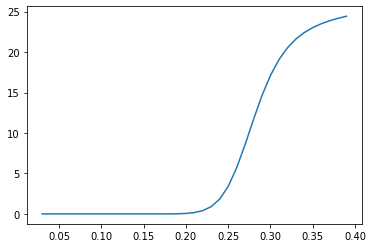

In [13]:
# test theta vs Esoil
es = np.zeros(len(np.arange(p.theta_r+0.01, p.theta_sat,0.01)))
i = 0
for sm in np.arange(p.theta_r+0.01, p.theta_sat,0.01):
# surface soil moisture 
    es[i] = main(sm)
    i += 1
#print(es)

plt.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es)


(37, 3)
0.0


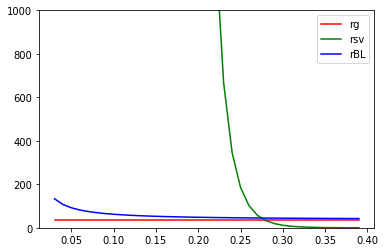

In [31]:
# test theta vs rg,rsv,rBL
es = np.zeros((len(np.arange(p.theta_r+0.01, p.theta_sat,0.01)),3))
print(es.shape)
print(es[1,2])
i = 0
for sm in np.arange(p.theta_r+0.01, p.theta_sat,0.01):
# surface soil moisture 
    es1,es2,es3 = main(sm)
    es[i,0],es[i,1],es[i,2] = es1,es2,es3
    #print(main(sm))
    i += 1
#print(es)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,0], color = 'r', label="rg")
ax.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,1], color = 'g', label="rsv")
ax.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,2], color = 'b', label="rBL")

ax.set_ylim(0,1000.)
ax.legend()

plt.show()

In [ ]:
# test bch, theta
es = np.zeros((len(np.arange(p.theta_r+0.10, p.theta_sat,0.01)),\
               len(np.arange(1.,12.,0.5)),3))
j = 0
for sm in np.arange(p.theta_r+0.10, p.theta_sat,0.01):
    i = 0
    for bch in np.arange(1.,12.,0.5):
        print(bch)
        es1,es2,es3 = main(sm, bch)
        es[j,i,0],es[j,i,1],es[j,i,2] = es1,es2,es3
        i += 1
    j += 1



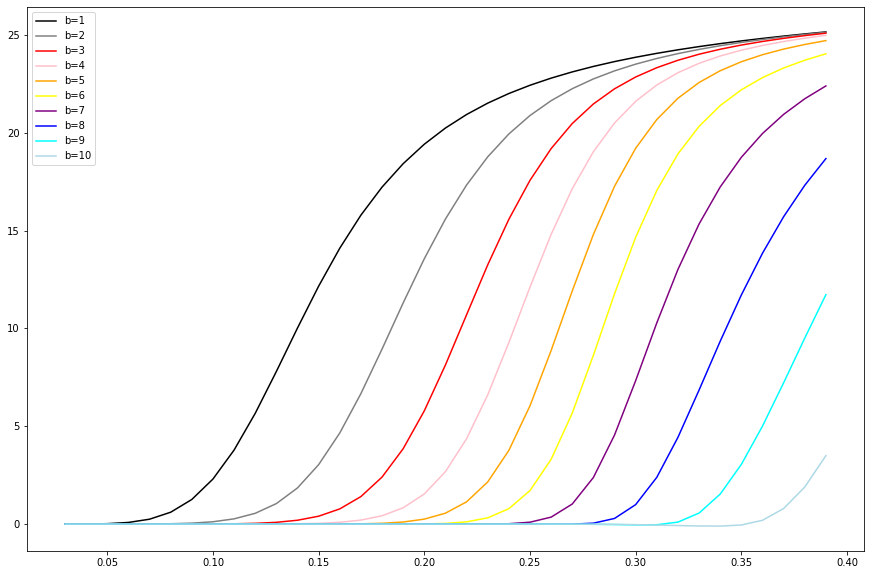

In [19]:
# test bch
es = np.zeros((len(np.arange(p.theta_r+0.01, p.theta_sat,0.01)),\
              len(np.arange(1.,11.,1))))

i = 0
for bch in np.arange(1.,11.,1):
    j = 0
    for sm in np.arange(p.theta_r+0.01, p.theta_sat,0.01):
        es1= main(sm, bch)
        es[j,i] = es1
        j += 1
    i += 1

fig = plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,0], color = 'black', label="b=1")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,1], color = 'gray', label="b=2")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,2], color = 'red', label="b=3")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,3], color = 'pink', label="b=4")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,4], color = 'orange', label="b=5")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,5], color = 'yellow', label="b=6")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,6], color = 'purple', label="b=7")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,7], color = 'blue', label="b=8")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,8], color = 'cyan', label="b=9")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,9], color = 'lightblue', label="b=10")
ax1.legend()
#ax1 = plt.plot(es[:,:])

#img1 = ax1.imshow(es[:,:])#,vmin=0, vmax=1000000)

#ax1.set(xticks=np.arange(len(np.arange(p.theta_r+0.01, p.theta_sat,0.01))), xticklabels=np.arange(p.theta_r+0.01, p.theta_sat,0.01)) 
#ax1.set(yticks=np.arange(len(np.arange(p.theta_r+0.10, p.theta_sat,0.01))), yticklabels=np.arange(p.theta_r+0.10, p.theta_sat,0.01))
#fig.colorbar(img1,orientation='horizontal',spacing='proportional',extend='both')
#fig.tight_layout()


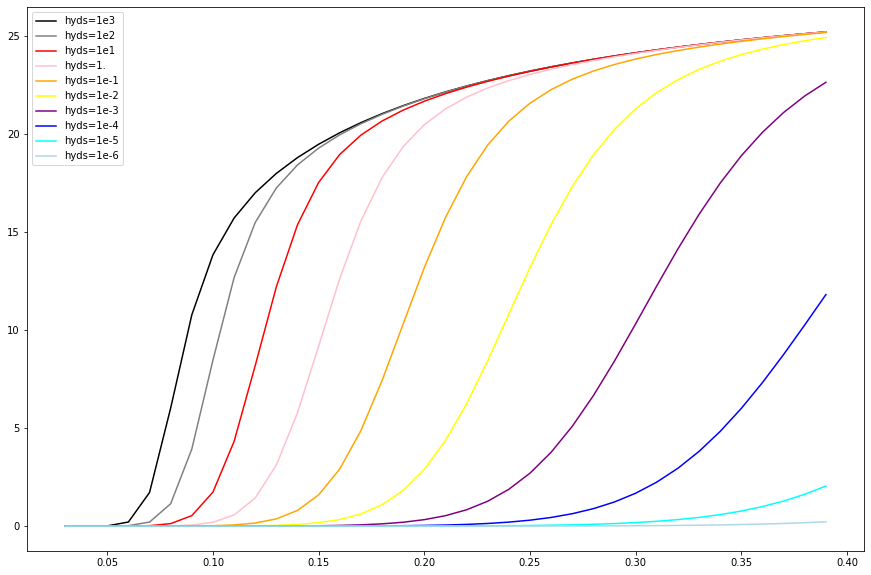

In [10]:
# test hyds
hyds = [1e3,1e2,1e1,1.,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
es = np.zeros((len(np.arange(p.theta_r+0.01, p.theta_sat,0.01)), len(hyds)))
bch = 3.
i = 0
for hk in hyds:
    j = 0
    for sm in np.arange(p.theta_r+0.01, p.theta_sat,0.01):
        es1= main(sm, hk , bch)
        es[j,i] = es1
        j += 1
    i += 1

fig = plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,0], color = 'black', label="hyds=1e3")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,1], color = 'gray', label="hyds=1e2")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,2], color = 'red', label="hyds=1e1")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,3], color = 'pink', label="hyds=1.")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,4], color = 'orange', label="hyds=1e-1")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,5], color = 'yellow', label="hyds=1e-2")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,6], color = 'purple', label="hyds=1e-3")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,7], color = 'blue', label="hyds=1e-4")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,8], color = 'cyan', label="hyds=1e-5")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,9], color = 'lightblue', label="hyds=1e-6")
ax1.legend()


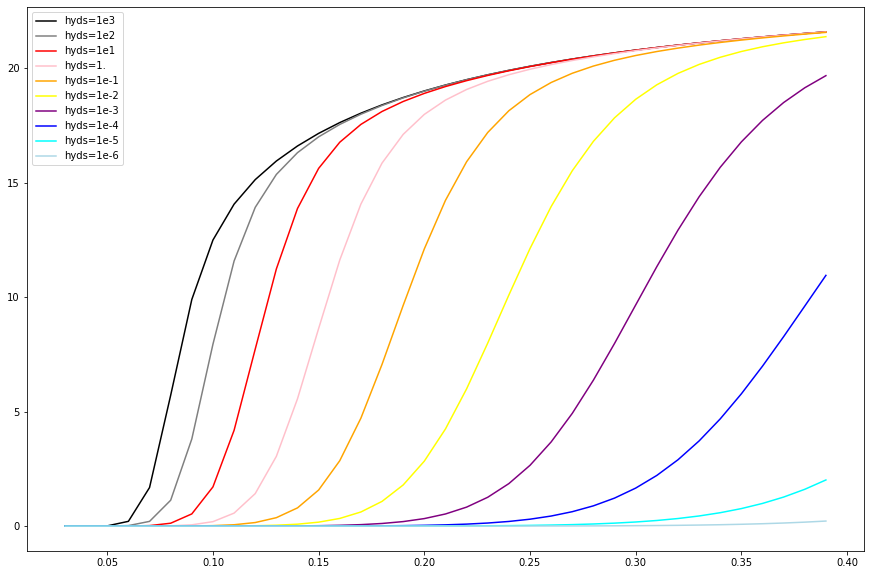

In [25]:
# test hyds
hyds = [1e3,1e2,1e1,1.,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
es = np.zeros((len(np.arange(p.theta_r+0.01, p.theta_sat,0.01)), len(hyds)))
bch = 3.
i = 0
for hk in hyds:
    j = 0
    for sm in np.arange(p.theta_r+0.01, p.theta_sat,0.01):
        es1= main(sm, hk , bch)
        es[j,i] = es1
        j += 1
    i += 1

fig = plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,0], color = 'black', label="hyds=1e3")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,1], color = 'gray', label="hyds=1e2")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,2], color = 'red', label="hyds=1e1")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,3], color = 'pink', label="hyds=1.")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,4], color = 'orange', label="hyds=1e-1")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,5], color = 'yellow', label="hyds=1e-2")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,6], color = 'purple', label="hyds=1e-3")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,7], color = 'blue', label="hyds=1e-4")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,8], color = 'cyan', label="hyds=1e-5")
ax1.plot(np.arange(p.theta_r+0.01, p.theta_sat,0.01),es[:,9], color = 'lightblue', label="hyds=1e-6")
ax1.legend()


 MMY rough%disp is    15.25058
 MMY rough%hruff is    20.00000
 MMY canopy%rghlai is    2.290000
*MMY rough%rt0us is    41.74260*
 MMY rough%disp is    15.25058
 
 MMY rough%z0soilsn is   1.0013655E-02
 
 MMY met%ua is    2.030000
 MMY canopy%us is   0.3037552
 MMY ssnow%rtevap_unsat is    10000.0000000000
 MMY ssnow%rtevap_sat is    511.400247875264
 MMY canopy%sublayer_dz is   2.875019843597649E-004
 MMY met%tvair is    281.7522
 MMY ssnow%qstss is   7.5363433E-03
 MMY ssnow%tss-C%tfrz is    9.911957
 MMY met%pmb is    1006.999
 MMY ssnow%rh_srf is   0.999994470977338
 MMY met%qvair is   3.6544970E-05
 MMY ssnow%potev is    2.263782
 
 '''
 MMY met%ua is    2.030000
 MMY canopy%us is   0.1840812
 MMY ssnow%rtevap_unsat is    10000.0000000000
 MMY ssnow%rtevap_sat is    479.746567121898
 MMY canopy%sublayer_dz is   4.024067093257720E-004
 MMY met%tvair is    281.6240
 MMY ssnow%qstss is   7.5363433E-03
 MMY ssnow%tss-C%tfrz is    9.911957
 MMY met%pmb is    1006.999
 MMY ssnow%rh_srf is   0.999994470977338
 MMY met%qvair is   4.0238039E-05
 MMY ssnow%potev is    2.252888
 '''
 
 MMY met%ua is    2.030000
 MMY canopy%us is   0.1227383
 MMY ssnow%rtevap_unsat is    10000.0000000000
 MMY ssnow%rtevap_sat is    453.504323045328
 MMY canopy%sublayer_dz is   6.018105991031246E-004
 MMY met%tvair is    281.4716
 MMY ssnow%qstss is   7.5363433E-03
 MMY ssnow%tss-C%tfrz is    9.911957
 MMY met%pmb is    1006.999
 MMY ssnow%rh_srf is   0.999994470977338
 MMY met%qvair is   4.4935776E-05
 MMY ssnow%potev is    2.257828
 
 MMY met%ua is    2.030000
 MMY canopy%us is   0.1227383
 MMY ssnow%rtevap_unsat is    10000.0000000000
 MMY ssnow%rtevap_sat is    453.504323045328
 MMY canopy%sublayer_dz is   6.018105991031246E-004
 MMY met%tvair is    281.4835
 MMY ssnow%qstss is   7.5363433E-03
 MMY ssnow%tss-C%tfrz is    9.911957
 MMY met%qvair is   4.0238039E-05
 MMY ssnow%potev is    2.252888
 
 MMY met%ua is    2.030000
 MMY canopy%us is   0.1227383
 MMY ssnow%rtevap_unsat is    10000.0000000000
 MMY ssnow%rtevap_sat is    453.504323045328
 MMY canopy%sublayer_dz is   6.018105991031246E-004
 MMY met%tvair is    281.4716
 MMY ssnow%qstss is   7.5363433E-03
 MMY ssnow%tss-C%tfrz is    9.911957
 MMY met%pmb is    1006.999
 MMY ssnow%rh_srf is   0.999994470977338
 MMY met%qvair is   4.4935776E-05
 MMY ssnow%potev is    2.257828
 
 MMY met%ua is    2.030000
 MMY canopy%us is   0.1227383
 MMY ssnow%rtevap_unsat is    10000.0000000000
 MMY ssnow%rtevap_sat is    453.504323045328
 MMY canopy%sublayer_dz is   6.018105991031246E-004
 MMY met%tvair is    281.4835
 MMY ssnow%qstss is   7.5363433E-03
 MMY ssnow%tss-C%tfrz is    9.911957

